In [2]:
start <- Sys.time() 


library(ggplot2)
library(reshape2)
library(rstatix)
library(dplyr)
library(tidyverse)
library(RColorBrewer)
library(ARTool)
library(readxl) 
library(ggsignif) 
library(seewave)
library(gsignal)
library(spectral)
library(onion)
library(fANCOVA) 
library(purrr)
library(inflection)
library(ggpubr)
library(ggrepel)
library(scales) 
library(lme4)
library(ggpmisc)
#library(numbers)
library(stringr)
library(dplyr) 
library(rstatix)
library(ggplot2)
library(ARTool)
library(caret)
#library(ggpmisc)
library(ggrepel)
library(ggpubr)
#library(arsenal) 
library(readxl) 
library(fANCOVA) 
library(ggpubr)
library(report)
library(lme4)
library(reshape2)  

# Function toround whole data frames (useful for reporting later)
round_df <- function(df, digits = 3) {
  nums <- vapply(df, is.numeric, FUN.VALUE = logical(1))
  df[,nums] <- round(df[,nums], digits = digits)
  (df)
}

# nice colors
cbPalette <- c("tomato1","steelblue2","#EEC900", "gray70","olivedrab4","lightpink4","darkorange2",'#D55E00')

Warning message:
"Paket 'report' wurde unter R Version 4.3.2 erstellt"


In [3]:
# We want to read all the logs in data folder
file_list <- list.files("data_upload/", full.names = TRUE) 
data <- NULL 
print(file_list)

for (file in file_list){ 
    df_tmp <- read.csv(file, sep=";", dec=",", header=F)
    print(file)
    df_tmp$file <- file  
    if (file != "data/desktop.ini") {
        data <- rbind(data, df_tmp)
    }
}

colnames(data) <- c("Time","biceps","triceps","upperleg","calf","SubjectID","condition","lightSwitch","file")

# Set all factors  
data[c('Muscle', 'Modality', 'Timing', 'Trial')] <- str_split_fixed(data$condition, '-', 4) 
data$SubjectID <- as.factor(data$SubjectID)
data$Muscle <- as.factor(data$Muscle)
data$Modality <- as.factor(data$Modality)
data$Timing <- as.factor(data$Timing)
data$Trial <- as.factor(data$Trial)
data$ID <- data$file <- data$condition <- data$Random <- NULL
data$lightSwitch <- as.factor(data$lightSwitch)  

# delete duplicate time slots
data <- data[!duplicated(data$Time), ]

# counter check levels
levels(data$Trial)
levels(data$Modality)
levels(data$Timing)
levels(data$SubjectID)
levels(data$Muscle)

# lights on
data <- data[data$lightSwitch == "on",] 

# getting duration through start time of each trial
trialTime <- aggregate(Time ~ Muscle + Modality + Timing + Trial + SubjectID, data, min)
trialTime <- do.call(data.frame, trialTime)                    
trialTime$startTime <- trialTime$Time
trialTime$Time <- NULL
data <- merge(data, trialTime)

# getting experimental trial time through start time of each subject
experimentTime <- aggregate(Time ~ SubjectID, data, min)
experimentTime <- do.call(data.frame, experimentTime)                    
experimentTime$experimentTime <- experimentTime$Time
experimentTime$Time <- NULL

data <- merge(data, experimentTime)

data$trialTime <- data$Time - data$startTime # trial duration in nano seconds
data$experimentTime <- data$Time - data$experimentTime # experiment duration in nano seconds
data$trialTime <- data$trialTime / 1000 / 1000  
data$experimentTime <- data$experimentTime / 1000 / 1000 

# No idea what I am doing with these values
data$EMGValue <- NA 
data$EMGTKEOValue <- NA 
data <- do.call(data.frame, data) 

#for (i in 1:nrow(data)) {   
    #data[i, "EMGValue"] <- data[i, as.character(data[i, "Muscle"])] 
#}  

data <- data %>% rowwise() %>% mutate(EMGValue = get(as.character(Muscle))) %>% ungroup()
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(minEMGValue = min(EMGValue))
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(maxEMGValue = max(EMGValue))

# Now we do this: https://www.researchgate.net/figure/EMG-signal-process-recommended-Green-The-raw-signal-no-treatment-was-applied-until_fig2_258344784

 [1] "data_upload/106_RawData_638212279346974801.csv"
 [2] "data_upload/107_RawData_638212398133542847.csv"
 [3] "data_upload/108_RawData_638213016789855139.csv"
 [4] "data_upload/109_RawData_638240662136220960.csv"
 [5] "data_upload/180_RawData_638243256220077257.csv"
 [6] "data_upload/182_RawData_638245845076551816.csv"
 [7] "data_upload/184_RawData_638246084791835915.csv"
 [8] "data_upload/186_RawData_638258809433667245.csv"
 [9] "data_upload/187_RawData_638258940018981630.csv"
[10] "data_upload/188_RawData_638259652938366600.csv"
[11] "data_upload/189_RawData_638259864144917902.csv"
[12] "data_upload/190_RawData_638264078947643465.csv"
[13] "data_upload/191_RawData_638264997626273428.csv"
[14] "data_upload/192_RawData_638270048981419009.csv"
[15] "data_upload/193_RawData_638270147733473558.csv"
[16] "data_upload/194_RawData_638270280944689015.csv"
[17] "data_upload/196_RawData_638272717750990399.csv"
[18] "data_upload/197_RawData_638276266518026080.csv"
[19] "data_upload/198_RawDat

[1] "1" "2"

[1] "EMS"       "nothing"   "Vibration" "Visual"

[1] "11" "13" "3"  "5"  "7"  "9"

[1] "106" "107" "108" "109" "111" "182" "184" "186" "187" "188" "189" "190"
[13] "191" "192" "193" "194" "196" "197" "198" "199" "200"

[1] "biceps"   "calf"     "triceps"  "upperleg"

In [4]:
# Using random TKEO https://rdrr.io/cran/seewave/man/TKEO.html with y[n] = x[n]^{2/m} - (x[n-M]*x[n+M])^{1/m} (Filtration)
dataTmp <- NULL
dataTmp <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(EMGTKEOValue = 
                                                                                   abs(as.data.frame(TKEO(EMGValue, f = 1000, channel = 1, m = 1, M = 1, plot = F, xlab = "Time (s)", ylab = "Energy"))[,2]))
# remove NAs
data <- na.omit(dataTmp)
dataTmp <- NULL

# not interested in negative values (Rectification)
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(minEMGTKEOValue = abs(min(EMGTKEOValue)))
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(maxEMGTKEOValue = max(EMGTKEOValue))

# normalize EMG and TKEO processed signal again
data$EMGValueNormalized <- (data$EMGValue - data$minEMGValue) / (data$maxEMGValue - data$minEMGValue)
data$EMGTKEOValueNormalized <- (data$EMGTKEOValue - data$minEMGTKEOValue) / (data$maxEMGTKEOValue - data$minEMGTKEOValue)
head(data)

Warning message:
"There were 170 warnings in `mutate()`.
The first warning was:
ℹ In argument: `EMGTKEOValue = abs(...)`.
ℹ In group 673: `SubjectID = 109`, `Muscle = triceps`, `Modality = EMS`, `Timing = 11`, `Trial = 1`.
Caused by warning in `c(wave[-(1:M)], rep(NA, M)) * c(rep(NA, M), wave[1:(length(wave) - M)])`:
! NAs durch Ganzzahlüberlauf erzeugt
ℹ Run `dplyr::last_dplyr_warnings()` to see the 169 remaining warnings."


SubjectID,Muscle,Modality,Timing,Trial,Time,biceps,triceps,upperleg,calf,⋯,experimentTime,trialTime,EMGValue,EMGTKEOValue,minEMGValue,maxEMGValue,minEMGTKEOValue,maxEMGTKEOValue,EMGValueNormalized,EMGTKEOValueNormalized
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
106,biceps,EMS,11,1,6.382124e+17,32980,32839,32663,30957,⋯,35049.23,0.009984,32980,1417678,12852,45327,18077,974932335,0.6197998,0.001435614
106,biceps,EMS,11,1,6.382124e+17,32958,32880,32917,30798,⋯,35049.24,0.019968,32958,5277284,12852,45327,18077,974932335,0.6191224,0.005394533
106,biceps,EMS,11,1,6.382124e+17,32776,32871,32939,31135,⋯,35049.25,0.030080,32776,6624392,12852,45327,18077,974932335,0.6135181,0.006776304
106,biceps,EMS,11,1,6.382124e+17,32796,32838,33047,31381,⋯,35049.33,0.110080,32796,3212448,12852,45327,18077,974932335,0.6141339,0.003276566
106,biceps,EMS,11,1,6.382124e+17,32718,32927,32999,31965,⋯,35049.34,0.120064,32718,6520320,12852,45327,18077,974932335,0.6117321,0.006669554
106,biceps,EMS,11,1,6.382124e+17,32839,32839,32855,32450,⋯,35049.44,0.220032,32839,18077,12852,45327,18077,974932335,0.6154580,0.000000000


In [5]:
# Smooth operator....
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(EMGSmoothedValue =  
    predict(loess(EMGTKEOValueNormalized  ~ trialTime, 
                  span = loess.as(EMGTKEOValueNormalized, trialTime, degree = 1, criterion = c("aicc", "gcv")[2], family = c("gaussian", "symmetric")[2], user.span = NULL, plot = F)$pars$span),
            trialTime))

data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(minEMGSmoothedValue = min(EMGSmoothedValue))
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(maxEMGSmoothedValue = max(EMGSmoothedValue))

data$EMGSmoothedValueNormalized <- (data$EMGSmoothedValue - data$minEMGSmoothedValue) / (data$maxEMGSmoothedValue - data$minEMGSmoothedValue)
head(data) 

num_trials <- unique(data$Trial)
num_timings <- unique(data$Timing)
num_modalities <- unique(data$Modality)
num_muscles <- unique(data$Muscle)
num_participants <- unique(data$SubjectID)

SubjectID,Muscle,Modality,Timing,Trial,Time,biceps,triceps,upperleg,calf,⋯,minEMGValue,maxEMGValue,minEMGTKEOValue,maxEMGTKEOValue,EMGValueNormalized,EMGTKEOValueNormalized,EMGSmoothedValue,minEMGSmoothedValue,maxEMGSmoothedValue,EMGSmoothedValueNormalized
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
106,biceps,EMS,11,1,6.382124e+17,32980,32839,32663,30957,⋯,12852,45327,18077,974932335,0.6197998,0.001435614,-0.005337102,-0.005337102,0.1257177,0.000000000
106,biceps,EMS,11,1,6.382124e+17,32958,32880,32917,30798,⋯,12852,45327,18077,974932335,0.6191224,0.005394533,-0.004939835,-0.005337102,0.1257177,0.003031302
106,biceps,EMS,11,1,6.382124e+17,32776,32871,32939,31135,⋯,12852,45327,18077,974932335,0.6135181,0.006776304,-0.004538164,-0.005337102,0.1257177,0.006096213
106,biceps,EMS,11,1,6.382124e+17,32796,32838,33047,31381,⋯,12852,45327,18077,974932335,0.6141339,0.003276566,-0.001389821,-0.005337102,0.1257177,0.030119317
106,biceps,EMS,11,1,6.382124e+17,32718,32927,32999,31965,⋯,12852,45327,18077,974932335,0.6117321,0.006669554,-0.001001200,-0.005337102,0.1257177,0.033084648
106,biceps,EMS,11,1,6.382124e+17,32839,32839,32855,32450,⋯,12852,45327,18077,974932335,0.6154580,0.000000000,0.002822986,-0.005337102,0.1257177,0.062264701


In [6]:
# BEDE takes a while
findBulgeStart <- function(x, y){
    cc <- check_curve(x, y) 
    ipbede <- bede(x, y, cc$index)
    #ipbede <- ifelse(!is.na(ipbede), ipbede, 20)
    return(as.numeric(ipbede$iplast))
}

timesPerSubjectWithTimings <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% 
    summarize(ipbede = findBulgeStart(trialTime, EMGSmoothedValueNormalized),
              .groups = 'drop')

timesPerSubjectWithTimings <- na.omit(timesPerSubjectWithTimings)

timesPerSubject <- timesPerSubjectWithTimings %>% group_by(SubjectID, Muscle, Modality) %>% 
    summarize(RT = mean(ipbede),
              RTLog = log(mean(ipbede)),
              RTmin = min(ipbede),
              RTLogmin = log(min(ipbede)),
              RTmax = max(ipbede),
              RTLogmax = log(max(ipbede)),
              .groups = 'drop')  

head(timesPerSubject)

SubjectID,Muscle,Modality,RT,RTLog,RTmin,RTLogmin,RTmax,RTLogmax
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
106,biceps,EMS,10.448584,2.346466,6.765120,1.911780,12.91674,2.558524
106,biceps,nothing,8.843001,2.179626,3.945856,1.372666,16.22035,2.786267
106,biceps,Vibration,9.997867,2.302372,8.420160,2.130629,13.12422,2.574460
106,biceps,Visual,9.131127,2.211689,5.492160,1.703322,11.91373,2.477691
106,calf,EMS,8.263387,2.111835,5.263872,1.660867,11.59738,2.450779
106,calf,nothing,8.283456,2.114260,5.991552,1.790350,10.61882,2.362628


In [7]:
round_df(timesPerSubject %>% group_by(Muscle, Modality) %>% shapiro_test(RT))

Muscle,Modality,variable,statistic,p
<fct>,<fct>,<chr>,<dbl>,<dbl>
biceps,EMS,RT,0.914,0.067
biceps,nothing,RT,0.971,0.765
biceps,Vibration,RT,0.931,0.142
biceps,Visual,RT,0.969,0.709
calf,EMS,RT,0.961,0.538
calf,nothing,RT,0.974,0.820
calf,Vibration,RT,0.944,0.263
calf,Visual,RT,0.979,0.910
triceps,EMS,RT,0.968,0.687


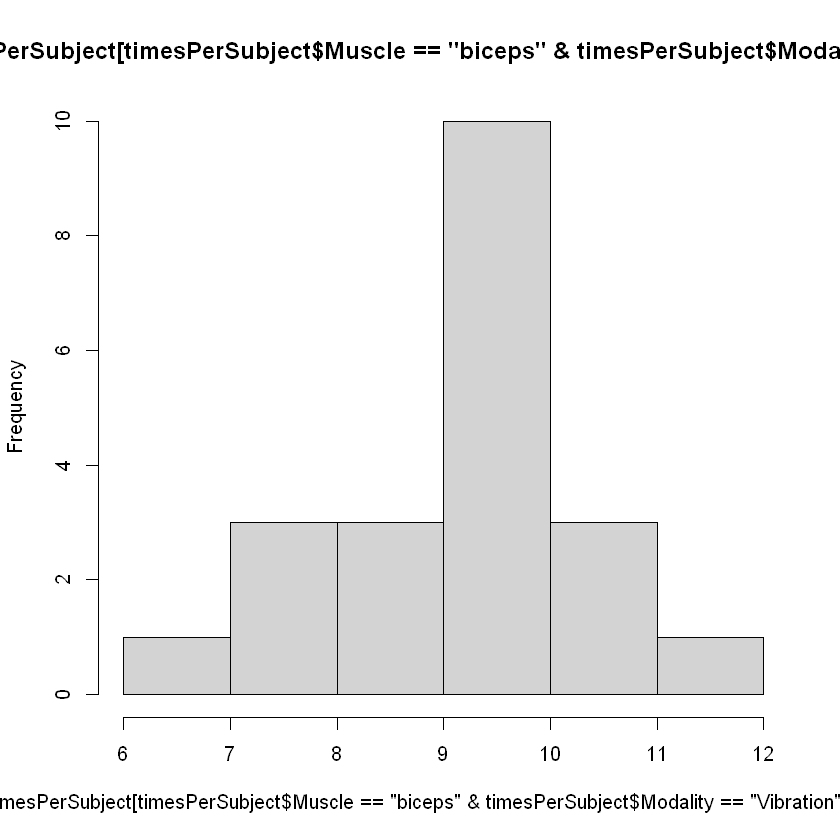

In [8]:
hist(timesPerSubject[timesPerSubject$Muscle == "biceps" & timesPerSubject$Modality == "Vibration",]$RT)

In [9]:
# Reaction times (we must log transform them because of normality)
means <- timesPerSubject %>% group_by(Muscle, Modality) %>% 
    summarize(ReactionTime = mean(RT),
              ReactionTimeCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RT) / sqrt(n()),
              ReactionTimeMin = mean(RTmin),
              ReactionTimeMinCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTmin) / sqrt(n()),
              ReactionTimeMax = mean(RTmax),
              ReactionTimeMaxCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTmax) / sqrt(n()),
              ReactionTimeLog = mean(RTLog),
              ReactionTimeLogCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTLog) / sqrt(n()),
              ReactionTimeLogMin = mean(RTLogmin),
              ReactionTimeLogMinCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTLogmin) / sqrt(n()),
              ReactionTimeLogMax = mean(RTLogmax),
              ReactionTimeLogMaxCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTLogmax) / sqrt(n()),
              N = n(),
              .groups = 'drop')  

means

Muscle,Modality,ReactionTime,ReactionTimeCI,ReactionTimeMin,ReactionTimeMinCI,ReactionTimeMax,ReactionTimeMaxCI,ReactionTimeLog,ReactionTimeLogCI,ReactionTimeLogMin,ReactionTimeLogMinCI,ReactionTimeLogMax,ReactionTimeLogMaxCI,N
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
biceps,EMS,9.197380,0.7758414,5.610222,0.8212974,13.22553,1.0829804,2.200237,0.09347263,1.671901,0.1558898,2.565169,0.08848056,21
biceps,nothing,9.588279,0.5325997,6.208762,0.6450024,13.50340,1.0013090,2.253490,0.05537230,1.799770,0.1088027,2.589599,0.07747222,21
biceps,Vibration,9.130664,0.5284833,4.990528,0.6756235,13.78572,1.0037051,2.203465,0.06057533,1.569790,0.1250930,2.611728,0.07173920,21
biceps,Visual,9.255126,0.6371363,6.181114,0.6207273,13.55666,1.0714498,2.213759,0.07147020,1.797625,0.1032797,2.591472,0.08341807,21
calf,EMS,8.090266,0.8633489,4.867017,0.7997989,12.90834,1.3926292,2.063070,0.11132063,1.522389,0.1613716,2.527087,0.12047547,21
calf,nothing,8.905512,0.7330748,5.381912,0.6454684,13.39479,1.2694518,2.169425,0.08920894,1.651956,0.1157803,2.571155,0.10575851,21
calf,Vibration,7.703934,0.7374343,4.797955,0.6777229,12.09880,1.1833776,2.018238,0.10415854,1.519841,0.1475447,2.468561,0.10637922,21
calf,Visual,7.495806,0.7318682,4.719546,0.6454586,11.65706,1.1569225,1.991568,0.10082940,1.510047,0.1340054,2.432774,0.10115991,21
triceps,EMS,8.762218,0.8006352,5.060517,0.7346991,12.99892,1.3459200,2.150648,0.09372696,1.577023,0.1367155,2.539011,0.10747145,21


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


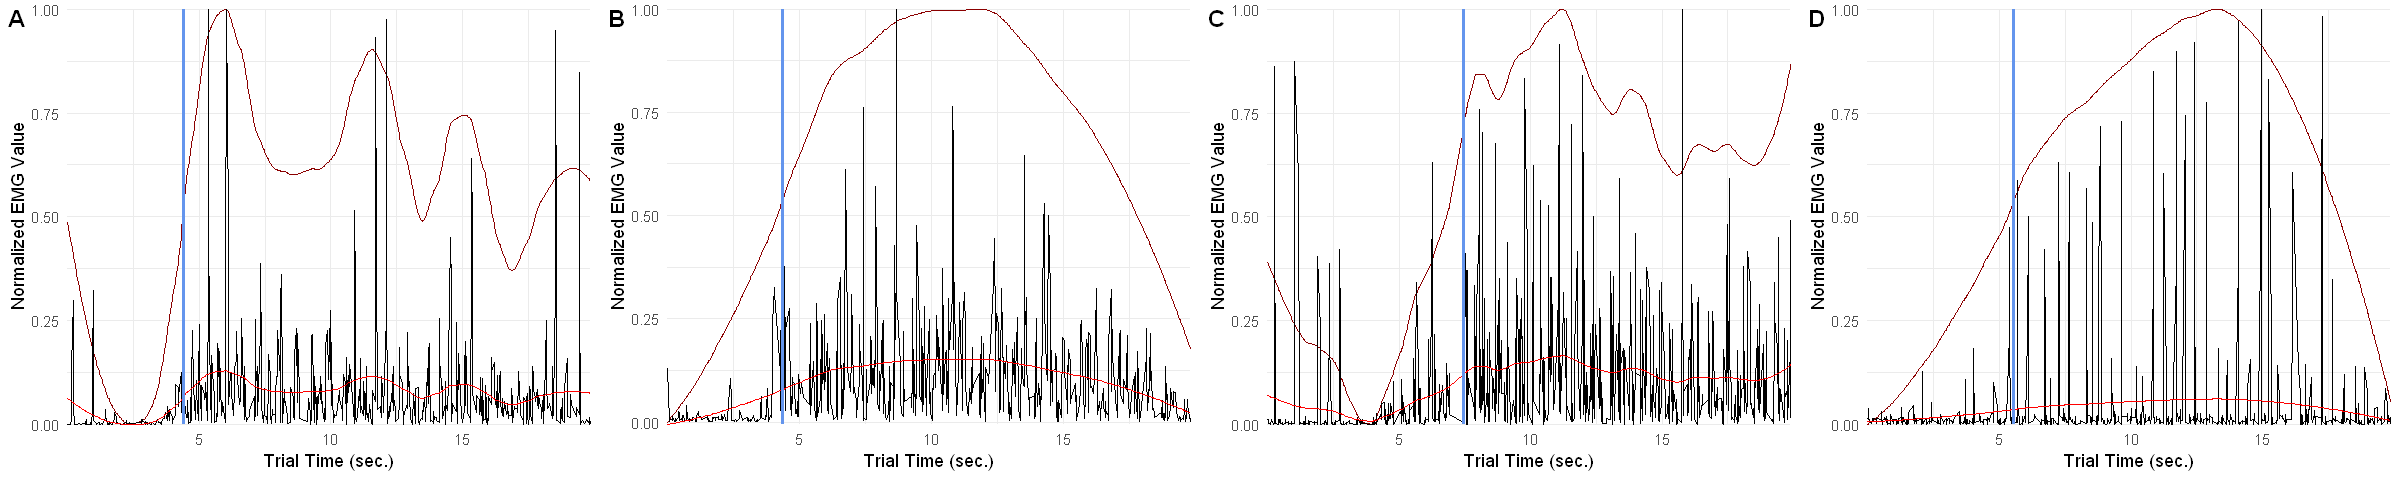

In [10]:
# example plots
dataTrial <- "1"
dataModality <- "EMS"
dataTiming <- "11"
dataSubjectID <- "108"
dataMuscle <- "biceps"

plotA <- ggplot(data[data$SubjectID == dataSubjectID & data$Muscle == dataMuscle & data$Modality == dataModality & data$Timing == dataTiming & data$Trial == dataTrial,],
               aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkred") + 
               geom_line(aes(y=EMGTKEOValueNormalized), size = 0.1)  + geom_line(aes(y=EMGSmoothedValue), color="red") +
               scale_color_manual(values = cbPalette) +
               xlab("Trial Time (sec.)") + 
               ylab("Normalized EMG Value") + 
               coord_cartesian(expand = FALSE) +   
               geom_vline(data=timesPerSubjectWithTimings[timesPerSubjectWithTimings$SubjectID == dataSubjectID &
                                                          timesPerSubjectWithTimings$Muscle == dataMuscle & 
                                                          timesPerSubjectWithTimings$Modality == dataModality&
                                                          timesPerSubjectWithTimings$Trial == dataTrial & 
                                                          timesPerSubjectWithTimings$Timing == dataTiming,], size = 1, mapping=aes(xintercept=ipbede), color="cornflowerblue")  +
               theme_minimal()
dataTrial <- "2"
dataModality <- "nothing"
dataTiming <- "11"
dataSubjectID <- "182"
dataMuscle <- "calf"

plotB <- ggplot(data[data$SubjectID == dataSubjectID & data$Muscle == dataMuscle & data$Modality == dataModality & data$Timing == dataTiming & data$Trial == dataTrial,],
               aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkred") + 
               geom_line(aes(y=EMGTKEOValueNormalized), size = 0.1)  + geom_line(aes(y=EMGSmoothedValue), color="red") +
               scale_color_manual(values = cbPalette) +
               xlab("Trial Time (sec.)") + 
               ylab("Normalized EMG Value") + 
               coord_cartesian(expand = FALSE) +  
               geom_vline(data=timesPerSubjectWithTimings[timesPerSubjectWithTimings$SubjectID == dataSubjectID &
                                                          timesPerSubjectWithTimings$Muscle == dataMuscle & 
                                                          timesPerSubjectWithTimings$Modality == dataModality&
                                                          timesPerSubjectWithTimings$Trial == dataTrial & 
                                                          timesPerSubjectWithTimings$Timing == dataTiming,], size = 1, mapping=aes(xintercept=ipbede), color="cornflowerblue")   +
               theme_minimal()


dataTrial <- "2"
dataModality <- "Vibration"
dataTiming <- "5"
dataSubjectID <- "191"
dataMuscle <- "triceps"

plotC <- ggplot(data[data$SubjectID == dataSubjectID & data$Muscle == dataMuscle & data$Modality == dataModality & data$Timing == dataTiming & data$Trial == dataTrial,],
               aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkred") + 
               geom_line(aes(y=EMGTKEOValueNormalized), size = 0.1)  + geom_line(aes(y=EMGSmoothedValue), color="red") +
               scale_color_manual(values = cbPalette) +
               xlab("Trial Time (sec.)") + 
               ylab("Normalized EMG Value") + 
               coord_cartesian(expand = FALSE) +  
               geom_vline(data=timesPerSubjectWithTimings[timesPerSubjectWithTimings$SubjectID == dataSubjectID &
                                                          timesPerSubjectWithTimings$Muscle == dataMuscle & 
                                                          timesPerSubjectWithTimings$Modality == dataModality&
                                                          timesPerSubjectWithTimings$Trial == dataTrial & 
                                                          timesPerSubjectWithTimings$Timing == dataTiming,], size = 1, mapping=aes(xintercept=ipbede), color="cornflowerblue")   +
               theme_minimal()


dataTrial <- "1"
dataModality <- "Visual"
dataTiming <- "11"
dataSubjectID <- "197"
dataMuscle <- "upperleg"

plotD <- ggplot(data[data$SubjectID == dataSubjectID & data$Muscle == dataMuscle & data$Modality == dataModality & data$Timing == dataTiming & data$Trial == dataTrial,],
               aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkred") + 
               geom_line(aes(y=EMGTKEOValueNormalized), size = 0.1, color="black")  + geom_line(aes(y=EMGSmoothedValue), color="red") +
               scale_color_manual(values = cbPalette) +
               xlab("Trial Time (sec.)") + 
               ylab("Normalized EMG Value") +   
               coord_cartesian(expand = FALSE) +  
               geom_vline(data=timesPerSubjectWithTimings[timesPerSubjectWithTimings$SubjectID == dataSubjectID &
                                                          timesPerSubjectWithTimings$Muscle == dataMuscle & 
                                                          timesPerSubjectWithTimings$Modality == dataModality&
                                                          timesPerSubjectWithTimings$Trial == dataTrial & 
                                                          timesPerSubjectWithTimings$Timing == dataTiming,], size = 1, mapping=aes(xintercept=ipbede), color="cornflowerblue") +
               theme_minimal()

options(repr.plot.width = 20, repr.plot.height = 4) 
plot <- ggarrange(plotA, plotB, plotC, plotD,
          labels = c("A", "B", "C", "D"),
          ncol = 4, nrow = 1)
plot
ggsave("ExamplesTKEOandBEDE.pdf", plot, width=14, height=3.5, device=cairo_pdf)

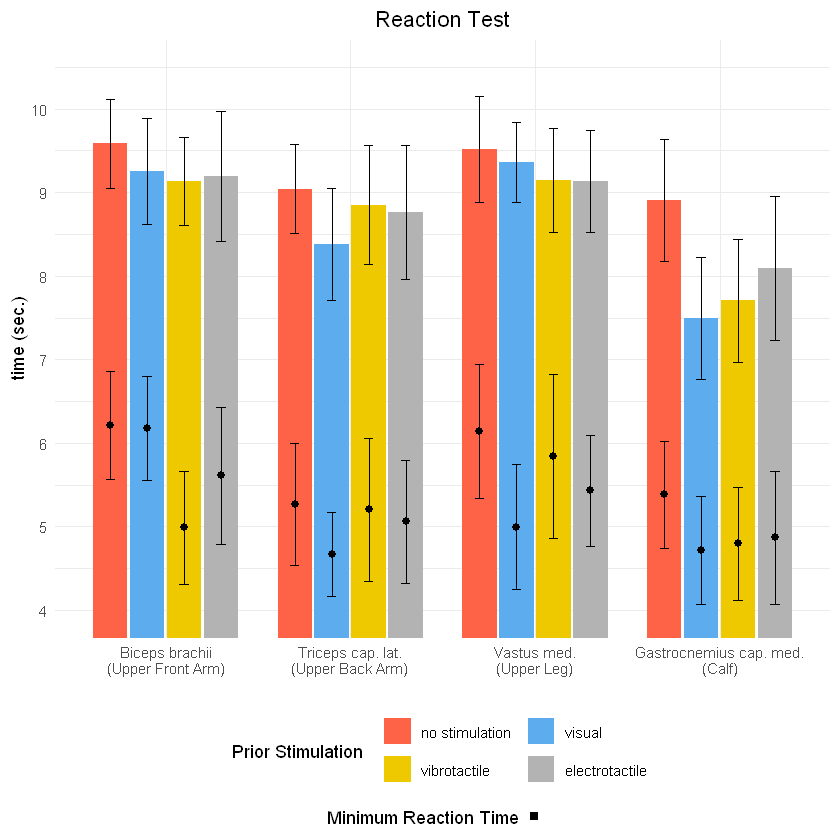

In [11]:
# we want to make it really, really beautiful

means <- timesPerSubject %>% group_by(Muscle, Modality) %>% 
    summarize(ReactionTime = mean(RT),
              ReactionTimeCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RT) / sqrt(n()),
              ReactionTimeMin = mean(RTmin),
              ReactionTimeMinCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTmin) / sqrt(n()),
              ReactionTimeMax = mean(RTmax),
              ReactionTimeMaxCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTmax) / sqrt(n()),
              ReactionTimeLog = mean(RTLog),
              ReactionTimeLogCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTLog) / sqrt(n()),
              ReactionTimeLogMin = mean(RTLogmin),
              ReactionTimeLogMinCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTLogmin) / sqrt(n()),
              ReactionTimeLogMax = mean(RTLogmax),
              ReactionTimeLogMaxCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTLogmax) / sqrt(n()),
              N = n(),
              .groups = 'drop')  

means$Modality <- factor(means$Modality, levels = c("nothing", "Visual", "Vibration", "EMS"))
means$Muscle <- factor(means$Muscle, levels = c("biceps", "triceps", "upperleg", "calf"))

means$Modality <- recode(means$Modality, nothing = "no stimulation",
                                         Visual = "visual",
                                         Vibration = "vibrotactile",
                                         EMS = "electrotactile")

means$Muscle <- recode(means$Muscle, biceps = "Biceps brachii\n(Upper Front Arm)", 
                                     triceps = "Triceps cap. lat.\n(Upper Back Arm)",
                                     upperleg = "Vastus med.\n(Upper Leg)",
                                     calf = "Gastrocnemius cap. med.\n(Calf)") 

plot <- ggplot(means, aes(y=ReactionTime, x=Muscle, fill=Modality)) +  
                        geom_bar(stat = "identity", position = position_dodge(width = 0.8), width=0.75) + 
                        geom_errorbar(aes(ymin = ReactionTime - ReactionTimeCI, ymax = ReactionTime + ReactionTimeCI),
                                      width=.2, position = position_dodge(width = 0.8), size = 0.3) + 
                        scale_y_continuous(breaks = scales::breaks_width(1)) +
                        coord_cartesian(ylim=c(4,10.5)) +   
                        geom_point(aes(y=ReactionTimeMin, x=Muscle, shape = ""), size = 2, position = position_dodge(width = 0.8)) + 
                        geom_errorbar(aes(ymin = ReactionTimeMin - ReactionTimeMinCI, ymax = ReactionTimeMin + ReactionTimeMinCI),
                                      width=.2, position = position_dodge(width = 0.8), size = 0.3) +  
                        ggtitle("Reaction Test") + 
                        ylab("time (sec.)") + 
                        xlab("") +  
                        labs(fill="Prior Stimulation   ", shape = "Minimum Reaction Time") + 
                        theme_minimal()  + 
                       # geom_signif(comparisons=list(c("True", "False")), annotations="p = 0.033", y_position = 6.75, tip_length = 0.1, vjust=-0.6) +
                        scale_fill_manual(values = cbPalette) + 
                        guides(fill = guide_legend(nrow=2, byrow=TRUE, override.aes = list(shape = NA), order = 2), 
                               shape = guide_legend(nrow=1, override.aes = list(shape = c(15)), byrow=TRUE), order = 1) +
                        theme(
                            plot.title = element_text(hjust = 0.5),
                            legend.position="bottom",
                            legend.box="vertical",
                            legend.margin=margin()
                        )
                                         
options(repr.plot.width = 7, repr.plot.height = 7) 
plot

ggsave("ReactionTimes.pdf", plot, width=5, height=5, device=cairo_pdf)

In [12]:
# ANOVA for reactions times
aov <- anova_test(data = timesPerSubject, dv = RTLog, wid = SubjectID, within = c(Modality, Muscle), effect.size = "pes")

aov
get_anova_table(aov, correction = "GG") 

pairwise.t.test(timesPerSubject$RTLog, timesPerSubject$Modality, p.adj = "bonf", paired = TRUE)
pairwise.t.test(timesPerSubject$RTLog, timesPerSubject$Muscle, p.adj = "bonf", paired = TRUE)

round_df(cohens_d(timesPerSubject, RTLog ~ Modality, paired = TRUE))
round_df(cohens_d(timesPerSubject, RTLog ~ Muscle, paired = TRUE))


ANOVA Table (type III tests)

$ANOVA
           Effect DFn DFd     F        p p<.05   pes
1        Modality   3  60 6.520 6.85e-04     * 0.246
2          Muscle   3  60 8.605 7.73e-05     * 0.301
3 Modality:Muscle   9 180 1.393 1.94e-01       0.065

$`Mauchly's Test for Sphericity`
           Effect     W     p p<.05
1        Modality 0.879 0.790      
2          Muscle 0.405 0.005     *
3 Modality:Muscle 0.063 0.398      

$`Sphericity Corrections`
           Effect   GGe       DF[GG]    p[GG] p[GG]<.05   HFe       DF[HF]
1        Modality 0.917  2.75, 55.05 0.001000         * 1.078   3.24, 64.7
2          Muscle 0.647  1.94, 38.82 0.000894         * 0.715  2.15, 42.92
3 Modality:Muscle 0.663 5.96, 119.25 0.223000           0.975 8.78, 175.55
     p[HF] p[HF]<.05
1 0.000685         *
2 0.000554         *
3 0.196000

,Effect,DFn,DFd,F,p,p<.05,pes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Modality,2.75,55.05,6.520,0.001000,*,0.246
2,Muscle,1.94,38.82,8.605,0.000894,*,0.301
3,Modality:Muscle,5.96,119.25,1.393,0.223000,,0.065



	Pairwise comparisons using paired t tests 

data:  timesPerSubject$RTLog and timesPerSubject$Modality 

          EMS     nothing Vibration
nothing   0.02331 -       -        
Vibration 1.00000 0.00316 -        
Visual    1.00000 0.00094 1.00000  

P value adjustment method: bonferroni 


	Pairwise comparisons using paired t tests 

data:  timesPerSubject$RTLog and timesPerSubject$Muscle 

         biceps  calf    triceps
calf     1.8e-06 -       -      
triceps  0.0231  0.0034  -      
upperleg 1.0000  3.0e-06 0.0592 

P value adjustment method: bonferroni 

.y.,group1,group2,effsize,n1,n2,magnitude
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<ord>
RTLog,EMS,nothing,-0.324,84,84,small
RTLog,EMS,Vibration,0.030,84,84,negligible
RTLog,EMS,Visual,0.101,84,84,negligible
RTLog,nothing,Vibration,0.394,84,84,small
RTLog,nothing,Visual,0.432,84,84,small
RTLog,Vibration,Visual,0.058,84,84,negligible


.y.,group1,group2,effsize,n1,n2,magnitude
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<ord>
RTLog,biceps,calf,0.608,84,84,moderate
RTLog,biceps,triceps,0.325,84,84,small
RTLog,biceps,upperleg,-0.009,84,84,negligible
RTLog,calf,triceps,-0.392,84,84,small
RTLog,calf,upperleg,-0.595,84,84,moderate
RTLog,triceps,upperleg,-0.288,84,84,small


Muscle,Modality,variable,statistic,p
<fct>,<fct>,<chr>,<dbl>,<dbl>
biceps,EMS,RTLogmin,0.964,0.592
biceps,nothing,RTLogmin,0.969,0.713
biceps,Vibration,RTLogmin,0.903,0.041
biceps,Visual,RTLogmin,0.988,0.993
calf,EMS,RTLogmin,0.966,0.651
calf,nothing,RTLogmin,0.966,0.653
calf,Vibration,RTLogmin,0.953,0.388
calf,Visual,RTLogmin,0.967,0.671
triceps,EMS,RTLogmin,0.956,0.436


ANOVA Table (type III tests)

$ANOVA
           Effect DFn DFd     F     p p<.05   pes
1        Modality   3  60 3.816 0.014     * 0.160
2          Muscle   3  60 3.733 0.016     * 0.157
3 Modality:Muscle   9 180 1.474 0.160       0.069

$`Mauchly's Test for Sphericity`
           Effect     W     p p<.05
1        Modality 0.743 0.353      
2          Muscle 0.859 0.723      
3 Modality:Muscle 0.045 0.211      

$`Sphericity Corrections`
           Effect   GGe      DF[GG] p[GG] p[GG]<.05   HFe       DF[HF] p[HF]
1        Modality 0.849 2.55, 50.92 0.020         * 0.983  2.95, 58.97 0.015
2          Muscle 0.912 2.74, 54.72 0.019         * 1.071  3.21, 64.24 0.016
3 Modality:Muscle 0.629 5.67, 113.3 0.197           0.907 8.16, 163.19 0.169
  p[HF]<.05
1         *
2         *
3

,Effect,DFn,DFd,F,p,p<.05,pes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Modality,3,60,3.816,0.014,*,0.160
2,Muscle,3,60,3.733,0.016,*,0.157
3,Modality:Muscle,9,180,1.474,0.160,,0.069


Muscle,Effect,DFn,DFd,F,p,p<.05,ges,p.adj
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
biceps,Modality,3,60,4.095,0.010,*,0.114,0.040
calf,Modality,3,60,1.786,0.160,,0.036,0.640
triceps,Modality,3,60,0.558,0.645,,0.018,1.000
upperleg,Modality,3,60,2.519,0.067,,0.061,0.268


,Muscle,.y.,group1,group2,n1,n2,statistic,df,p,p.adj,p.adj.signif
,<fct>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,biceps,RTLogmin,EMS,nothing,21,21,-1.42800521,20,0.169,1.000,ns
2,biceps,RTLogmin,EMS,Vibration,21,21,1.26796045,20,0.219,1.000,ns
3,biceps,RTLogmin,EMS,Visual,21,21,-2.23422311,20,0.037,0.222,ns
4,biceps,RTLogmin,nothing,Vibration,21,21,2.47839784,20,0.022,0.133,ns
5,biceps,RTLogmin,nothing,Visual,21,21,0.03041270,20,0.976,1.000,ns
6,biceps,RTLogmin,Vibration,Visual,21,21,-3.31071806,20,0.003,0.021,*
7,calf,RTLogmin,EMS,nothing,21,21,-1.52360786,20,0.143,0.858,ns
8,calf,RTLogmin,EMS,Vibration,21,21,0.03877777,20,0.969,1.000,ns
9,calf,RTLogmin,EMS,Visual,21,21,0.20292477,20,0.841,1.000,ns


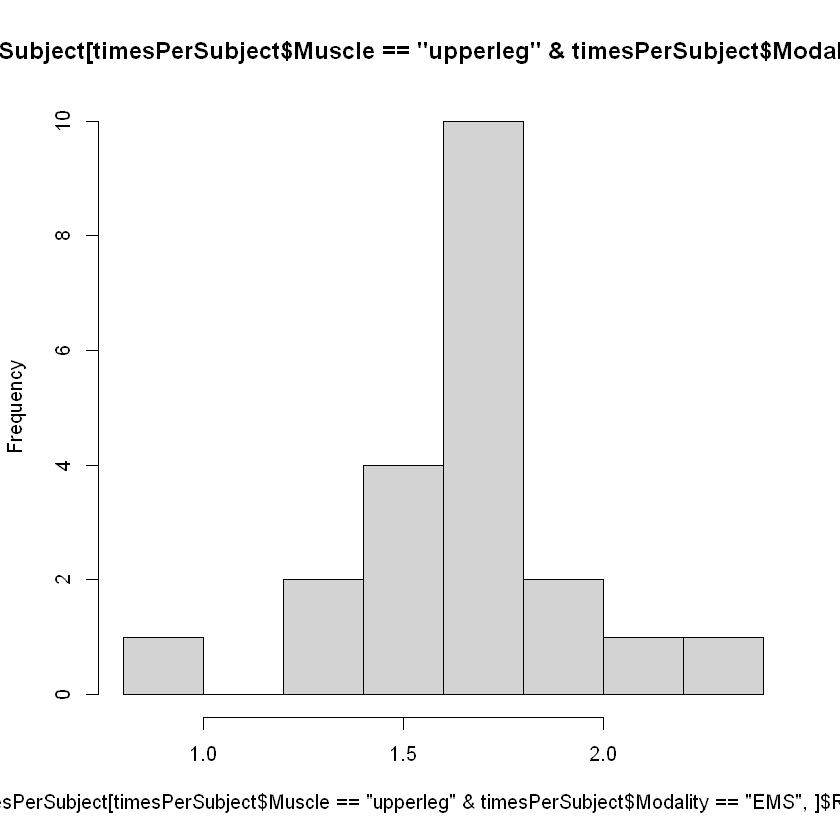

In [13]:
# ANOVA with the faster sample
round_df(timesPerSubject %>% group_by(Muscle, Modality) %>% shapiro_test(RTLogmin))

hist(timesPerSubject[timesPerSubject$Muscle == "upperleg" & timesPerSubject$Modality== "EMS",]$RTLogmin)

aov <- anova_test(data = timesPerSubject, dv = RTmin, wid = SubjectID, within = c(Modality, Muscle), effect.size = "pes")
aov
get_anova_table(aov, correction = "auto") 

# Interaction effect, we must look into the muscles
timesPerSubject %>% group_by(Muscle) %>% anova_test(dv = RTLogmin, wid = SubjectID, within = Modality) %>% get_anova_table() %>% adjust_pvalue(method = "bonferroni")

# biceps and upperleg are significant. let's do the t-tests
timesPerSubject %>% group_by(Muscle) %>% pairwise_t_test(RTLogmin ~ Modality, paired = TRUE, p.adjust.method = "bonferroni" )

In [14]:
# max is eigentlich egal

aov <- anova_test(data = timesPerSubject, dv = RTmax, wid = SubjectID, within = c(Muscle, Modality), effect.size = "pes")
get_anova_table(aov, correction = "auto") 

,Effect,DFn,DFd,F,p,p<.05,pes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Muscle,2.07,41.41,2.497,0.093,,0.111
2,Modality,3.00,60.00,0.237,0.870,,0.012
3,Muscle:Modality,9.00,180.00,1.542,0.136,,0.072


,trialTimeS,Muscle,Modality,EMGValue,EMGValueNormalized,EMGTKEOValue,EMGTKEOValueNormalized,EMGSmoothedValueNormalized
,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,biceps,EMS,32656.20,0.4803815,32272262,0.02641185,0.2993885
2,2,biceps,EMS,32933.22,0.4976055,36170760,0.02944700,0.2541353
3,3,biceps,EMS,32973.94,0.4958277,51177365,0.04370648,0.2617695
4,4,biceps,EMS,32882.92,0.5025905,40264458,0.03522900,0.2927406
5,5,biceps,EMS,32987.66,0.5093470,40121184,0.03429034,0.2808883
6,6,biceps,EMS,32983.36,0.5162740,29453117,0.02505264,0.2616370


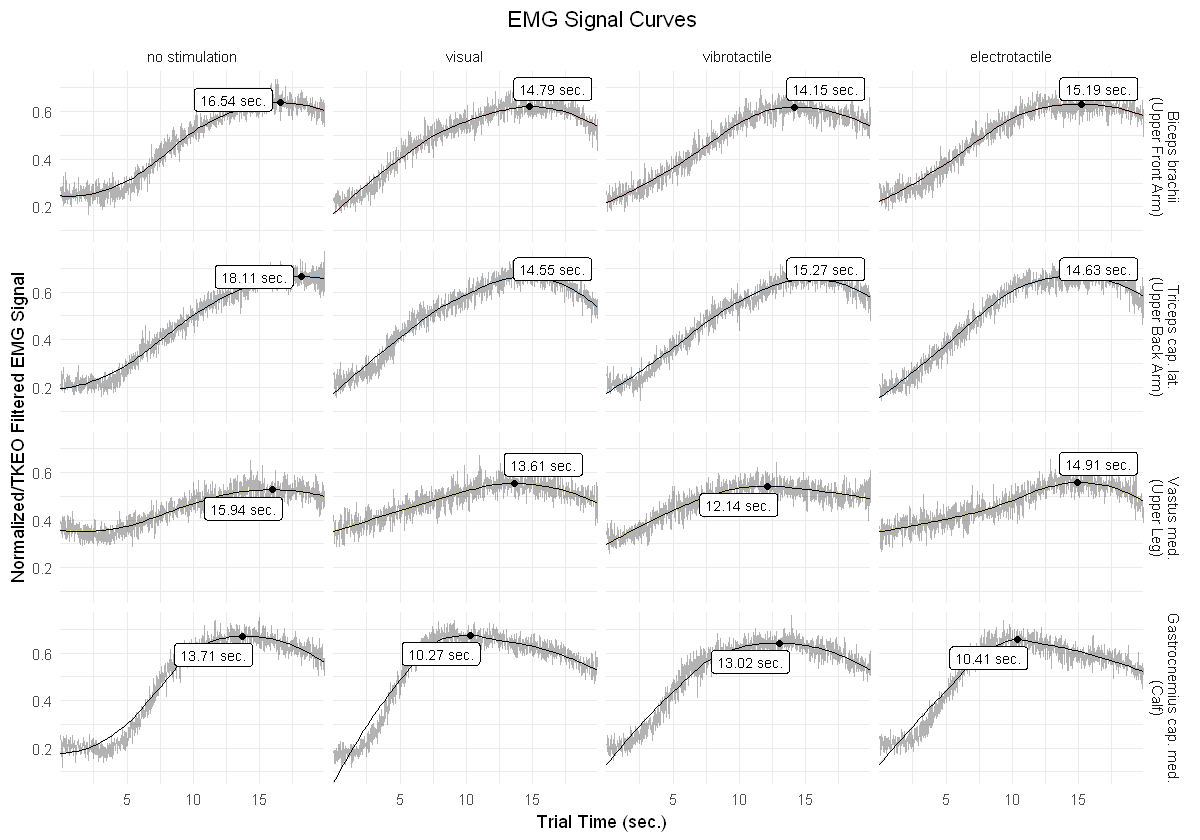

In [15]:
# the world is not enough, we need precise inflections points

inflectionPoint <- function(x, y) {
    xl <- seq(min(x), max(x), (max(x) - min(x)) / 1000)
    suppressWarnings( out <- predict(loess(y~x), xl))
    infl <- c(FALSE, diff(diff(out)>0) != 0)
    c(tail(xl[infl], n=1), tail(out[infl], n = 1))
}   
 
data$trialTimeS <- round(data$trialTime, 2) 

meanData <- aggregate(cbind(EMGValue, EMGValueNormalized, EMGTKEOValue, EMGTKEOValueNormalized, EMGSmoothedValueNormalized) ~ as.factor(trialTimeS) + Muscle + Modality, data[(data$trialTimeS) < 19.9, ], mean)
colnames(meanData) <- c("trialTimeS", "Muscle","Modality", "EMGValue", "EMGValueNormalized", "EMGTKEOValue", "EMGTKEOValueNormalized", "EMGSmoothedValueNormalized")
meanData$trialTimeS <- as.numeric(meanData$trialTimeS)
#head(data)
head(meanData)

df <- meanData %>% group_by(Muscle, Modality) %>% mutate(x1 = inflectionPoint(trialTimeS, EMGSmoothedValueNormalized)[1],
                                                         x2 = inflectionPoint(trialTimeS, EMGSmoothedValueNormalized)[2])
df <- aggregate(cbind(df$x1, df$x2), by=list(df$Muscle, df$Modality), mean)

df <- do.call(data.frame, df)
colnames(df) <- c("Muscle", "Modality", "trialTimeS", "EMGSmoothedValueNormalized") 

df$Modality <- factor(df$Modality, levels = c("nothing", "Visual", "Vibration", "EMS"))
df$Muscle <- factor(df$Muscle, levels = c("biceps", "triceps", "upperleg", "calf")) 

df$Modality <- recode(df$Modality, nothing = "no stimulation",
                                         Visual = "visual",
                                         Vibration = "vibrotactile",
                                         EMS = "electrotactile")

df$Muscle <- recode(df$Muscle, biceps = "Biceps brachii\n(Upper Front Arm)", 
                                     triceps = "Triceps cap. lat.\n(Upper Back Arm)",
                                     upperleg = "Vastus med.\n(Upper Leg)",
                                     calf = "Gastrocnemius cap. med.\n(Calf)") 

meanData$Modality <- factor(meanData$Modality, levels = c("nothing", "Visual", "Vibration", "EMS"))
meanData$Muscle <- factor(meanData$Muscle, levels = c("biceps", "triceps", "upperleg", "calf")) 

meanData$Modality <- recode(meanData$Modality, nothing = "no stimulation",
                                         Visual = "visual",
                                         Vibration = "vibrotactile",
                                         EMS = "electrotactile")

meanData$Muscle <- recode(meanData$Muscle, biceps = "Biceps brachii\n(Upper Front Arm)", 
                                     triceps = "Triceps cap. lat.\n(Upper Back Arm)",
                                     upperleg = "Vastus med.\n(Upper Leg)",
                                     calf = "Gastrocnemius cap. med.\n(Calf)") 

# beautiful TKEO corrected sample 
plot <- ggplot(meanData, aes(x = trialTimeS/ 100, y = EMGSmoothedValueNormalized, color = Muscle, fill = Muscle)) +  
            facet_grid(Muscle ~ Modality) + 
            #geom_errorbar(aes(ymin = mean, ymax = mean), width=0, alpha=0.5, size=0.5) +  
            #scale_x_continuous(breaks = scales::breaks_width(5)) +
            #coord_cartesian(xlim = c(0, 20), expand = FALSE) + 
            #scale_y_continuous(breaks = scales::breaks_width(0.1), limits=c(0,0.3)) +
            geom_line(size = 0.3, alpha = .3, color = "black") + 
            geom_smooth(data = meanData, size = 0.3, method = 'loess', formula = "y ~ x", color = "black") +
            #geom_smooth() +
            coord_cartesian(expand = FALSE) +  
            geom_point(data = df, color = "black") + 
            ggtitle("EMG Signal Curves") + 
            #ggtitle("GSR Signal Stress Test") +
            #geom_wrap(.~Muscle) + 
            geom_label_repel(data = df, label = paste("",round(df$trialTimeS/ 100, 2),"~sec."), fill="white", color = "black", size=3, show.legend = FALSE, parse = TRUE) + #, "plain('sec')~italic('|')", round(df$EMGSmoothedValueNormalized, 2), " max.", sep="~"
            ylab("Normalized/TKEO Filtered EMG Signal") + 
            #geom_point(data = peaks, aes(x=pos/10,y=val, color="blue"))+
            xlab("Trial Time (sec.)") +  
            scale_color_manual(values = cbPalette) +
            scale_fill_manual(values = cbPalette) +
            theme_minimal() + 
            theme(
                plot.title = element_text(hjust = 0.5),
                legend.position = "none"
            ) 
options(repr.plot.width = 10, repr.plot.height = 7) 
plot
ggsave("ReactionCurves.pdf", plot, width=10, height=7, device=cairo_pdf)

In [16]:
# we want to do this for each trial to do an ANOVA on each saddle (maximum signal strength)

inflectionPoint <- function(x, y) {
    xl <- seq(min(x), max(x), (max(x) - min(x)) / 1000)
    suppressWarnings( out <- predict(loess(y~x), xl))
    infl <- c(FALSE, diff(diff(out)>0) != 0)
    c(tail(xl[infl], n=1), tail(out[infl], n = 1))
}   
 
data$trialTimeS <- round(data$trialTime, 2) 

meanData <- aggregate(cbind(EMGValue, EMGValueNormalized, EMGTKEOValue, EMGTKEOValueNormalized, EMGSmoothedValueNormalized) ~ SubjectID + Muscle + Modality + as.factor(trialTimeS), data[(data$trialTimeS) < 19.9, ], mean)
colnames(meanData) <- c("SubjectID", "Muscle","Modality", "trialTimeS", "EMGValue", "EMGValueNormalized", "EMGTKEOValue", "EMGTKEOValueNormalized", "EMGSmoothedValueNormalized")
meanData$trialTimeS <- as.numeric(meanData$trialTimeS)
#head(data)

df <- meanData %>% group_by(SubjectID, Muscle, Modality) %>% mutate(x1 = inflectionPoint(trialTimeS, EMGSmoothedValueNormalized)[1],
                                                                    x2 = inflectionPoint(trialTimeS, EMGSmoothedValueNormalized)[2])
length(is.na(df))
head(df)

dfPerSubject <- aggregate(cbind(df$x1, df$x2), by=list(df$SubjectID, df$Muscle, df$Modality), mean)

dfPerSubject <- do.call(data.frame, dfPerSubject)
colnames(dfPerSubject) <- c("SubjectID", "Muscle", "Modality", "trialTimeS", "EMGSmoothedValueNormalized")
head(dfPerSubject)

[1] 7228419

SubjectID,Muscle,Modality,trialTimeS,EMGValue,EMGValueNormalized,EMGTKEOValue,EMGTKEOValueNormalized,EMGSmoothedValueNormalized,x1,x2
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
186,biceps,EMS,1,33998.00,0.5592755,83294372,0.065266432,0.19198332,1234.180,0.7753750
187,biceps,EMS,1,32809.90,0.5052169,4109390,0.003114077,0.13509322,1361.476,0.7518703
188,biceps,EMS,1,32832.73,0.5003007,47151791,0.034916652,0.36567641,1222.246,0.4776041
189,biceps,EMS,1,32773.75,0.3496046,13642758,0.012152932,0.07971723,1301.806,0.7179550
190,biceps,EMS,1,32836.12,0.4234339,6593643,0.005883756,0.37632831,NA,NA
191,biceps,EMS,1,32633.36,0.4921208,43722770,0.037229939,0.07964204,NA,NA


,SubjectID,Muscle,Modality,trialTimeS,EMGSmoothedValueNormalized
,<fct>,<fct>,<fct>,<dbl>,<dbl>
1,106,biceps,EMS,1584.448,0.6988384
2,107,biceps,EMS,1485.048,0.5499884
3,108,biceps,EMS,1021.844,0.7713049
4,109,biceps,EMS,1566.556,0.7405086
5,111,biceps,EMS,1552.640,0.8348523
6,182,biceps,EMS,1485.048,0.7747269


Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."


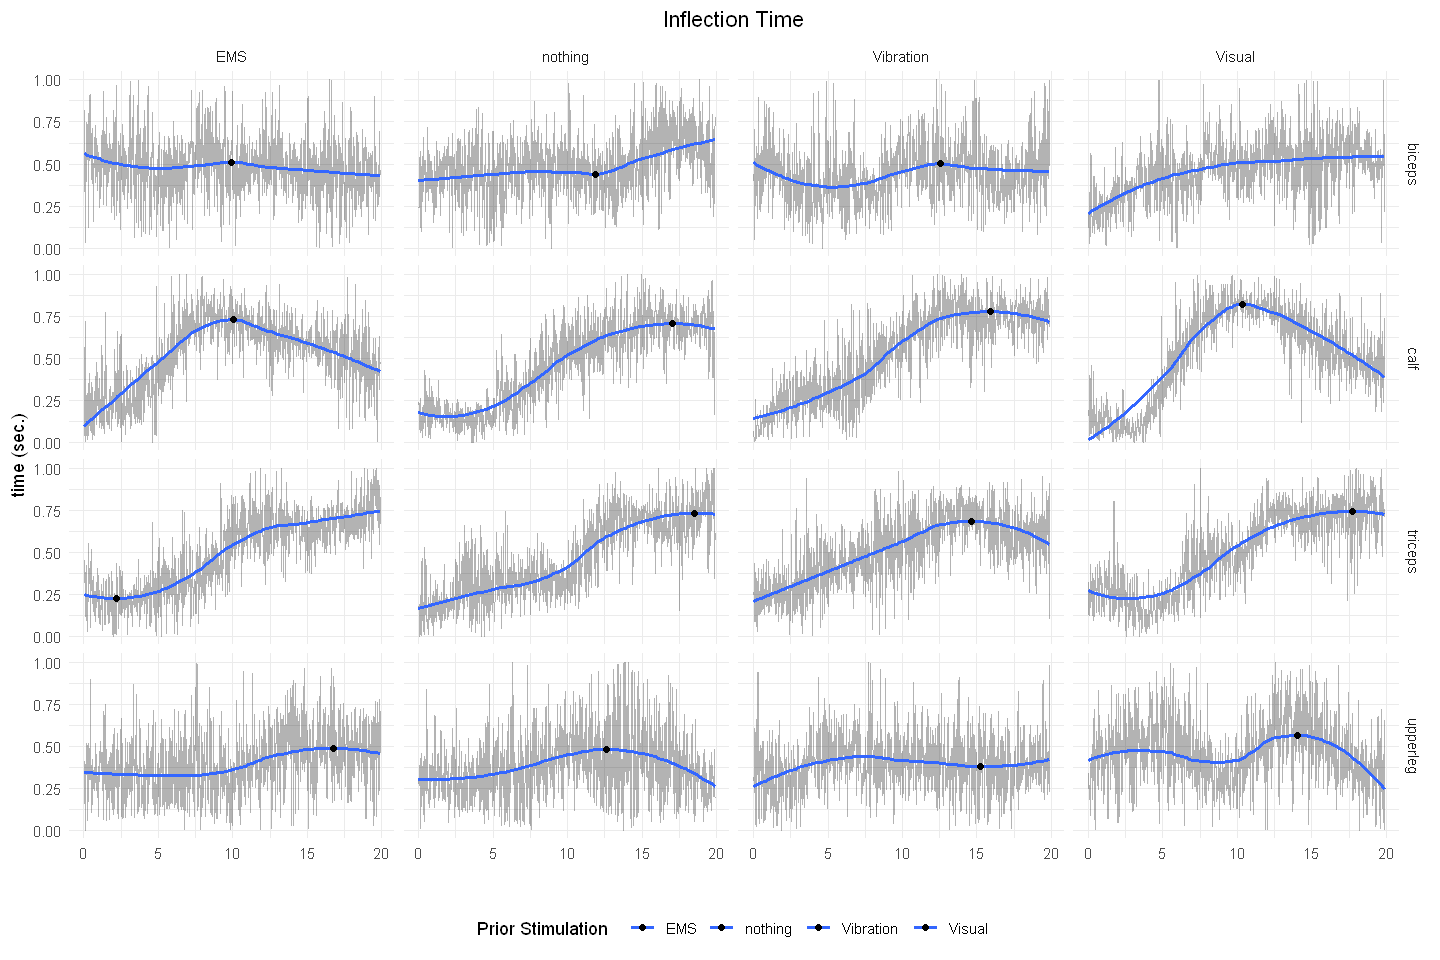

In [17]:
# nope

plot <- ggplot(meanData[meanData$SubjectID == "193",], aes(y=EMGSmoothedValueNormalized, x=trialTimeS / 100, fill=Modality)) +  
                        facet_grid(Muscle ~ Modality) + 
                        #geom_bar(stat = "identity", position = position_dodge(width = 0.8), width=0.75) + 
                        #geom_errorbar(aes(ymin = EMGInflection - EMGInflectionCI, ymax = EMGInflection + EMGInflectionCI),
                                      #width=.2, position = position_dodge(width = 0.8), size = 0.3) + 
                        geom_line(size = 0.3, alpha = .3, color = "black") + 
                        geom_smooth(method = 'loess', formula = "y ~ x", se = FALSE) +
                        #scale_y_continuous(breaks = scales::breaks_width(1)) +
                        #coord_cartesian(ylim=c(4,11)) +   
                       # geom_point(data = maxResult[maxResult$SubjectID == "193",], color = "red") + 
                        geom_point(data = dfPerSubject[dfPerSubject$SubjectID == "193",], color = "black") +  
                        ggtitle("Inflection Time") + 
                        ylab("time (sec.)") + 
                        xlab("") +  
                        labs(fill="Prior Stimulation   ", shape = NULL) +
                        theme_minimal()  + 
                       # geom_signif(comparisons=list(c("True", "False")), annotations="p = 0.033", y_position = 6.75, tip_length = 0.1, vjust=-0.6) +
                        scale_fill_manual(values = cbPalette) +
                        theme(
                            plot.title = element_text(hjust = 0.5),
                            legend.position="bottom"
                        )
                                         
options(repr.plot.width = 12, repr.plot.height = 8) 
plot


SubjectID,Muscle,Modality,Timing,Trial,Time,biceps,triceps,upperleg,calf,⋯,maxEMGValue,minEMGTKEOValue,maxEMGTKEOValue,EMGValueNormalized,EMGTKEOValueNormalized,EMGSmoothedValue,minEMGSmoothedValue,maxEMGSmoothedValue,EMGSmoothedValueNormalized,trialTimeS
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<int>,<int>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
106,biceps,EMS,11,1,6.382124e+17,33991,29873,32917,32098,⋯,45327,18077,974932335,0.6509315,0.016061119,0.12571770,-0.005337102,0.12571770,1,14.45
106,biceps,EMS,13,1,6.382124e+17,33104,34174,31768,32614,⋯,43684,20545,830612456,0.5840214,0.061531903,0.07390257,0.017042164,0.07390257,1,13.77
106,biceps,EMS,3,1,6.382123e+17,33516,28562,32877,32253,⋯,43478,0,820407580,0.2747525,0.073923452,0.11269572,0.017526185,0.11269572,1,18.91
106,biceps,EMS,5,1,6.382123e+17,31330,32387,32742,32338,⋯,47943,29554,1245533365,0.4642869,0.035174574,0.08691302,-0.001281356,0.08691302,1,16.34
106,biceps,EMS,7,1,6.382124e+17,32839,32775,32989,32167,⋯,44650,25601,1000637625,0.6354855,0.002732688,0.12705884,0.032455858,0.12705884,1,0.01
106,biceps,EMS,9,1,6.382124e+17,32946,26438,30408,37465,⋯,47056,5476,1148892334,0.5727738,0.498167843,0.15438518,0.004622346,0.15438518,1,19.82


Muscle,Modality,variable,statistic,p
<fct>,<fct>,<chr>,<dbl>,<dbl>
biceps,EMS,RTLog,0.824,0.002
biceps,nothing,RTLog,0.959,0.504
biceps,Vibration,RTLog,0.964,0.595
biceps,Visual,RTLog,0.934,0.164
calf,EMS,RTLog,0.920,0.086
calf,nothing,RTLog,0.920,0.087
calf,Vibration,RTLog,0.951,0.361
calf,Visual,RTLog,0.981,0.932
triceps,EMS,RTLog,0.939,0.205


ANOVA Table (type III tests)

$ANOVA
           Effect DFn DFd      F        p p<.05   pes
1        Modality   3  60  3.069 3.50e-02     * 0.133
2          Muscle   3  60 13.627 6.92e-07     * 0.405
3 Modality:Muscle   9 180  1.661 1.01e-01       0.077

$`Mauchly's Test for Sphericity`
           Effect     W     p p<.05
1        Modality 0.768 0.423      
2          Muscle 0.544 0.044     *
3 Modality:Muscle 0.030 0.076      

$`Sphericity Corrections`
           Effect   GGe       DF[GG]    p[GG] p[GG]<.05   HFe      DF[HF]
1        Modality 0.853   2.56, 51.2 4.30e-02         * 0.989 2.97, 59.35
2          Muscle 0.772  2.31, 46.29 9.26e-06         * 0.878 2.64, 52.71
3 Modality:Muscle 0.575 5.17, 103.44 1.48e-01           0.799 7.19, 143.8
     p[HF] p[HF]<.05
1 3.50e-02         *
2 2.74e-06         *
3 1.21e-01

,Effect,DFn,DFd,F,p,p<.05,pes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Modality,3.00,60.00,3.069,0.035,*,0.133
2,Muscle,2.31,46.29,13.627,0.000,*,0.405
3,Modality:Muscle,9.00,180.00,1.661,0.101,,0.077



	Pairwise comparisons using Wilcoxon signed rank test with continuity correction 

data:  meansPerSubject$RTLog and meansPerSubject$Modality 

          EMS    nothing Vibration
nothing   0.1501 -       -        
Vibration 1.0000 0.0153  -        
Visual    0.9485 0.0068  1.0000   

P value adjustment method: bonferroni 


	Pairwise comparisons using Wilcoxon signed rank test with continuity correction 

data:  meansPerSubject$RTLog and meansPerSubject$Muscle 

         biceps  calf    triceps
calf     4.8e-05 -       -      
triceps  1       3.1e-05 -      
upperleg 6.6e-07 1       2.0e-06

P value adjustment method: bonferroni 

.y.,group1,group2,effsize,n1,n2,magnitude
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<ord>
RTLog,EMS,nothing,-0.247,84,84,small
RTLog,EMS,Vibration,0.006,84,84,negligible
RTLog,EMS,Visual,0.039,84,84,negligible
RTLog,nothing,Vibration,0.286,84,84,small
RTLog,nothing,Visual,0.319,84,84,small
RTLog,Vibration,Visual,0.038,84,84,negligible


.y.,group1,group2,effsize,n1,n2,magnitude
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<ord>
RTLog,biceps,calf,0.519,84,84,moderate
RTLog,biceps,triceps,-0.028,84,84,negligible
RTLog,biceps,upperleg,0.636,84,84,moderate
RTLog,calf,triceps,-0.570,84,84,moderate
RTLog,calf,upperleg,0.092,84,84,negligible
RTLog,triceps,upperleg,0.652,84,84,moderate


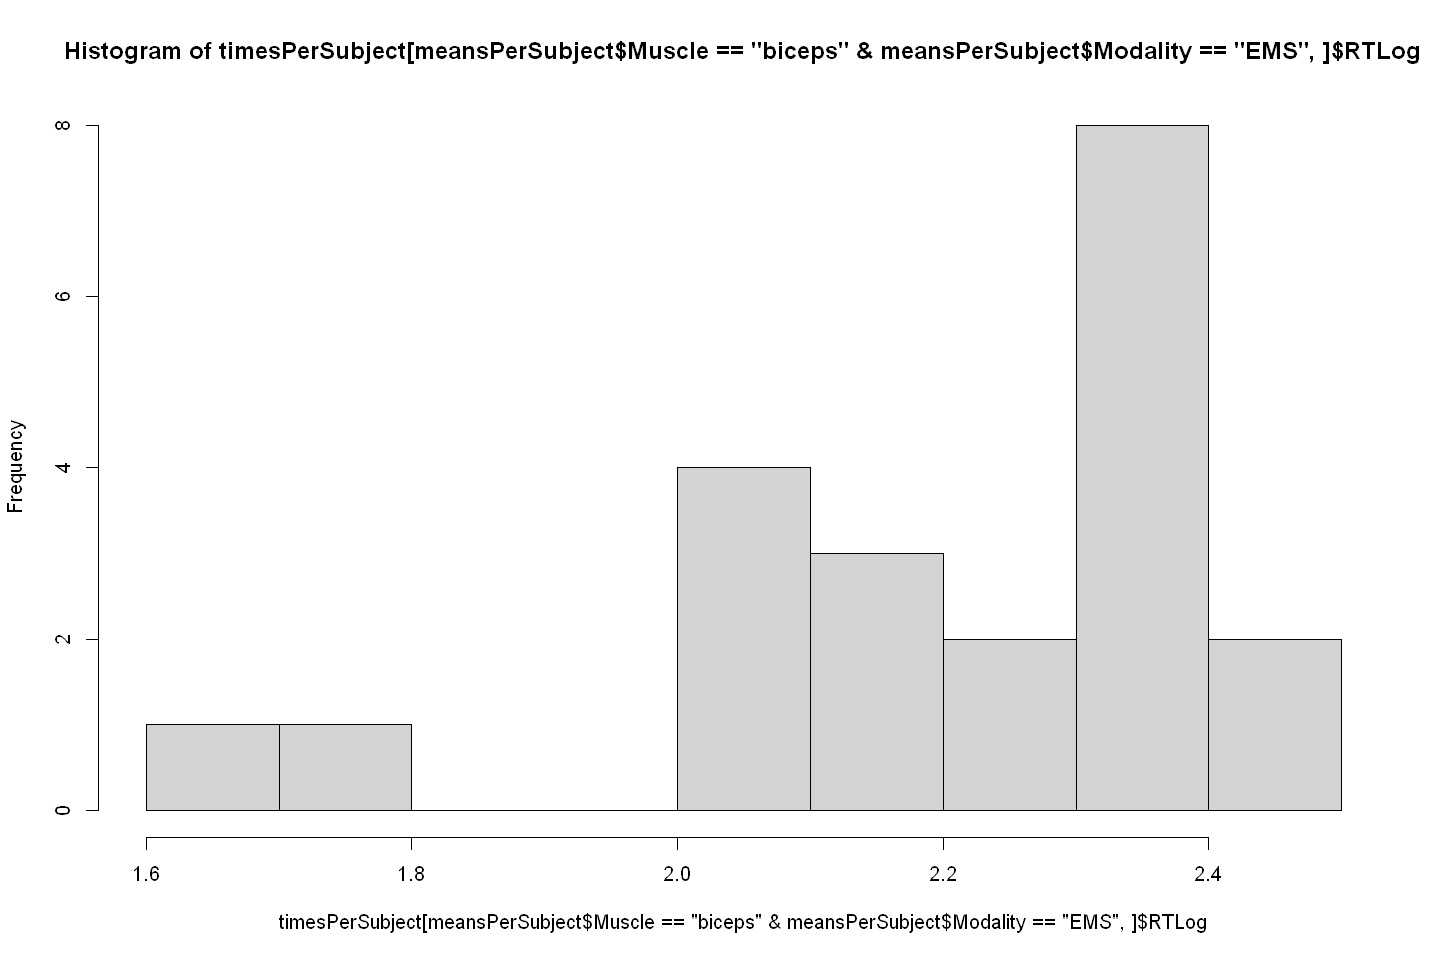

In [18]:
# we want to have the time at the maximum value of the smoothed signal

maxResult <- data[(data$trialTimeS) < 19.9, ] %>% group_by(SubjectID, Muscle, Modality, Trial, Timing) %>% arrange(desc(EMGSmoothedValueNormalized)) %>% slice(1) %>% ungroup()
head(maxResult)

meansPerSubject <- na.omit(maxResult) %>% group_by(SubjectID, Muscle, Modality) %>% 
    summarize(RT = mean(trialTimeS),
              RTLog = log(mean(trialTimeS)),
              N = n(),
              .groups = 'drop')   

round_df(meansPerSubject %>% group_by(Muscle, Modality) %>% shapiro_test(RTLog))

aov <- anova_test(data = meansPerSubject, dv = RTLog, wid = SubjectID, within = c(Modality,Muscle), effect.size = "pes")
aov
round_df(get_anova_table(aov, correction = "auto") )

#m = art(RTLog ~ Muscle * Modality + (1|SubjectID), data=meansPerSubject) # linear mixed model syntax; see lme4::lmer
#round_df(anova(m))

hist(timesPerSubject[meansPerSubject$Muscle == "biceps" & meansPerSubject$Modality== "EMS",]$RTLog)

pairwise.wilcox.test(meansPerSubject$RTLog, meansPerSubject$Modality, p.adj = "bonf", paired = TRUE)
pairwise.wilcox.test(meansPerSubject$RTLog, meansPerSubject$Muscle, p.adj = "bonf", paired = TRUE)


round_df(cohens_d(meansPerSubject, RTLog ~ Modality, paired = TRUE))
round_df(cohens_d(meansPerSubject, RTLog ~ Muscle, paired = TRUE))

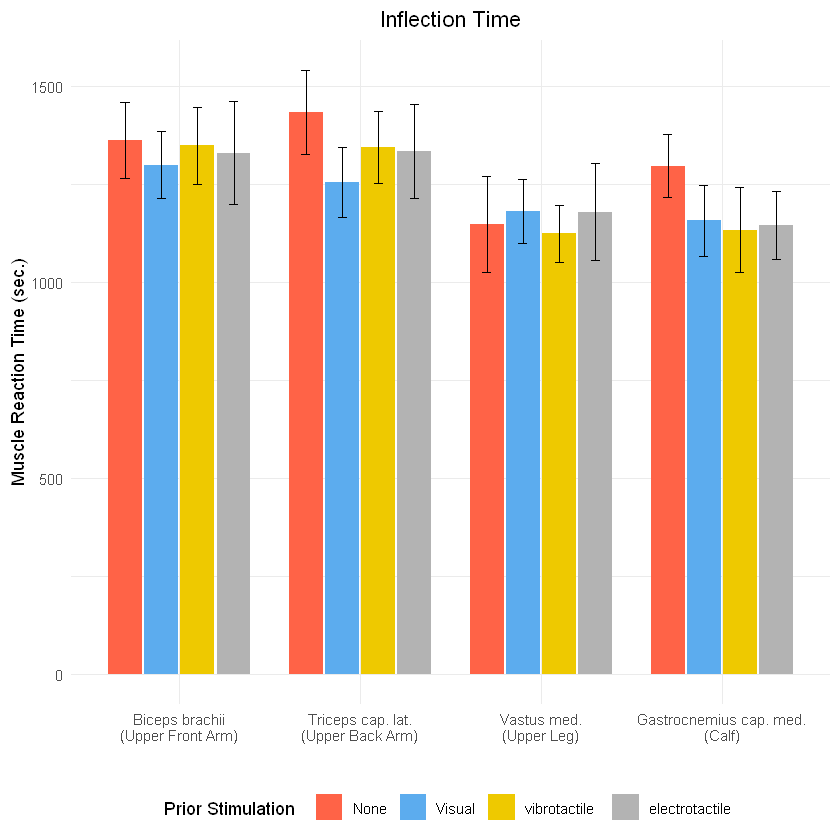

In [19]:
# let check

means <- meansPerSubject %>% group_by(Muscle, Modality) %>% 
    summarize(EMGInflection = mean(RT * 100),
              EMGInflectionCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RT * 100) / sqrt(n()), 
              N = n(),
              .groups = 'drop')   

means$Modality <- factor(means$Modality, levels = c("nothing", "Visual", "Vibration", "EMS"))
means$Muscle <- factor(means$Muscle, levels = c("biceps", "triceps", "upperleg", "calf"))

means$Modality <- recode(means$Modality, nothing = "None",
                                         Visual = "Visual",
                                         Vibration = "vibrotactile",
                                         EMS = "electrotactile")

means$Muscle <- recode(means$Muscle, biceps = "Biceps brachii\n(Upper Front Arm)", 
                                     triceps = "Triceps cap. lat.\n(Upper Back Arm)",
                                     upperleg = "Vastus med.\n(Upper Leg)",
                                     calf = "Gastrocnemius cap. med.\n(Calf)") 

plot <- ggplot(means, aes(y=EMGInflection, x=Muscle, fill=Modality)) +  
                        geom_bar(stat = "identity", position = position_dodge(width = 0.8), width=0.75) + 
                        geom_errorbar(aes(ymin = EMGInflection - EMGInflectionCI, ymax = EMGInflection + EMGInflectionCI),
                                      width=.2, position = position_dodge(width = 0.8), size = 0.3) + 
                        #scale_y_continuous(breaks = scales::breaks_width(1)) +
                        #coord_cartesian(ylim=c(4,11)) +   
                        ggtitle("Inflection Time") + 
                        ylab("Muscle Reaction Time (sec.)") + 
                        xlab("") +  
                        labs(fill="Prior Stimulation   ", shape = NULL) +
                        theme_minimal()  + 
                       # geom_signif(comparisons=list(c("True", "False")), annotations="p = 0.033", y_position = 6.75, tip_length = 0.1, vjust=-0.6) +
                        scale_fill_manual(values = cbPalette) +
                        theme(
                            plot.title = element_text(hjust = 0.5),
                            legend.position="bottom"
                        )
                                         
options(repr.plot.width = 7, repr.plot.height = 7) 
plot

ggsave("EMGInflectionTimes.pdf", plot, width=7, height=7, device=cairo_pdf)

# don't put this into this paper, looks ugly :)

In [20]:
# Do Amplitude and Reaction Time change over time?

library(nlme)
library(MuMIn)

findBulgeStart <- function(x, y){
    cc <- check_curve(x, y) 
    ipbede <- bede(x, y, cc$index)
    #ipbede <- ifelse(!is.na(ipbede), ipbede, 20)
    return(as.numeric(ipbede$iplast))
}

timesAndAmpsPerSubject <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% 
    summarize(ReactionTime = findBulgeStart(trialTime, EMGSmoothedValueNormalized),
              EMGAmplitude = mean(EMGSmoothedValueNormalized),
              ExperimentTime = max(experimentTime),
              .groups = 'drop') 

timesAndAmpsPerSubject <- na.omit(timesAndAmpsPerSubject) 
head(timesAndAmpsPerSubject)
print("LM Model")
lm <- lm(ReactionTime ~ ExperimentTime * Muscle,  timesAndAmpsPerSubject) 
summary(lm)
round_df(anova(lm))

print("LME Model")
lme <- lme(EMGAmplitude ~ ExperimentTime * Muscle, random = ~1|SubjectID,  timesAndAmpsPerSubject)
r.squaredGLMM(lme)
summary(lme)
round_df(anova(lme))


round_df(timesAndAmpsPerSubject %>% group_by(Muscle) %>% cor_test(ReactionTime, EMGAmplitude))

plotVals <- melt(timesAndAmpsPerSubject, id.vars = c("SubjectID", "Muscle", "Modality", "Timing", "Trial", "ExperimentTime"),
                                   measure.vars = c("ReactionTime", "EMGAmplitude"))

colnames(plotVals) <- c("SubjectID", "Muscle", "Modality","Timing","Trial","ExperimentTime","Measure","Value")

plotVals <- aggregate(Value ~ SubjectID + Muscle + ExperimentTime + Measure, plotVals, mean)
plotVals <- do.call(data.frame, plotVals)
colnames(plotVals) <- c("SubjectID", "Muscle", "ExperimentTime","Measure","Value")
plotVals$ExperimentTime <- as.numeric(plotVals$ExperimentTime)
head(plotVals)

levels(plotVals$Measure) <- c("Reaction Time (in sec.)", "Normalized EMG Amplitude")

plotVals$Muscle <- factor(plotVals$Muscle, levels = c("biceps", "triceps", "upperleg", "calf"))

plotVals$Muscle <- recode(plotVals$Muscle, biceps = "Biceps brachii\n(Upper Front Arm)", 
                                     triceps = "Triceps cap. lat.\n(Upper Back Arm)",
                                     upperleg = "Vastus med.\n(Upper Leg)",
                                     calf = "Gastrocnemius cap. med.\n(Calf)")  

Warning message:
"Paket 'nlme' wurde unter R Version 4.3.2 erstellt"

Attache Paket: 'nlme'


Das folgende Objekt ist maskiert 'package:lme4':

    lmList


Das folgende Objekt ist maskiert 'package:dplyr':

    collapse




SubjectID,Muscle,Modality,Timing,Trial,ReactionTime,EMGAmplitude,ExperimentTime
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
106,biceps,EMS,11,1,11.215680,0.6125091,35069.094
106,biceps,EMS,13,1,9.102784,0.5336238,34288.802
106,biceps,EMS,13,2,12.515392,0.3819380,19684.929
106,biceps,EMS,3,1,11.854016,0.4883991,1580.191
106,biceps,EMS,5,1,8.174464,0.5316618,14203.517
106,biceps,EMS,7,1,6.765120,0.4867861,25426.445


[1] "LM Model"



Call:
lm(formula = ReactionTime ~ ExperimentTime * Muscle, data = timesAndAmpsPerSubject)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.0993 -2.3559 -0.2976  1.9840 10.1574 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    9.358e+00  2.590e-01  36.137   <2e-16 ***
ExperimentTime                -9.346e-06  1.167e-05  -0.801   0.4233    
Musclecalf                    -8.496e-01  3.571e-01  -2.379   0.0174 *  
Muscletriceps                 -8.488e-01  3.635e-01  -2.335   0.0196 *  
Muscleupperleg                -4.305e-02  3.630e-01  -0.119   0.9056    
ExperimentTime:Musclecalf     -1.982e-05  1.600e-05  -1.239   0.2156    
ExperimentTime:Muscletriceps   1.844e-05  1.641e-05   1.123   0.2614    
ExperimentTime:Muscleupperleg  6.985e-06  1.651e-05   0.423   0.6722    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.1 on 2412 degrees of freedom
Multiple R-squared:

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ExperimentTime,1,26.564,26.564,2.763,0.097
Muscle,3,681.205,227.068,23.621,0.000
ExperimentTime:Muscle,3,59.303,19.768,2.056,0.104
Residuals,2412,23186.747,9.613,NA,NA


[1] "LME Model"


Warning message:
"'r.squaredGLMM' now calculates a revised statistic. See the help page."


R2m,R2c
0.01858306,0.07914657


Linear mixed-effects model fit by REML
  Data: timesAndAmpsPerSubject 
        AIC      BIC   logLik
  -3947.392 -3889.51 1983.696

Random effects:
 Formula: ~1 | SubjectID
        (Intercept) Residual
StdDev:  0.02632814 0.102662

Fixed effects:  EMGAmplitude ~ ExperimentTime * Muscle 
                                   Value   Std.Error   DF  t-value p-value
(Intercept)                    0.4791442 0.010335741 2392 46.35799  0.0000
ExperimentTime                 0.0000003 0.000000387 2392  0.81919  0.4128
Musclecalf                     0.0424279 0.011858885 2392  3.57773  0.0004
Muscletriceps                  0.0308995 0.012078648 2392  2.55819  0.0106
Muscleupperleg                -0.0019993 0.012043220 2392 -0.16601  0.8682
ExperimentTime:Musclecalf     -0.0000007 0.000000531 2392 -1.27136  0.2037
ExperimentTime:Muscletriceps  -0.0000008 0.000000546 2392 -1.46507  0.1430
ExperimentTime:Muscleupperleg -0.0000002 0.000000548 2392 -0.45162  0.6516
 Correlation: 
                      

,numDF,denDF,F-value,p-value
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1,2392,6563.727,0.000
ExperimentTime,1,2392,0.251,0.617
Muscle,3,2392,15.172,0.000
ExperimentTime:Muscle,3,2392,0.943,0.419


Muscle,var1,var2,cor,statistic,p,conf.low,conf.high,method
<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
biceps,ReactionTime,EMGAmplitude,-0.20,-4.787,0.000,-0.275,-0.117,Pearson
calf,ReactionTime,EMGAmplitude,-0.37,-9.952,0.000,-0.431,-0.297,Pearson
triceps,ReactionTime,EMGAmplitude,-0.20,-5.208,0.000,-0.278,-0.128,Pearson
upperleg,ReactionTime,EMGAmplitude,-0.12,-2.981,0.003,-0.202,-0.042,Pearson


,SubjectID,Muscle,ExperimentTime,Measure,Value
,<fct>,<fct>,<dbl>,<fct>,<dbl>
1,107,triceps,19.61907,ReactionTime,8.837184
2,188,biceps,19.71840,ReactionTime,10.784384
3,109,triceps,19.76525,ReactionTime,8.058048
4,194,upperleg,19.78394,ReactionTime,7.809088
5,190,calf,19.80083,ReactionTime,7.115584
6,198,upperleg,19.80339,ReactionTime,8.068864


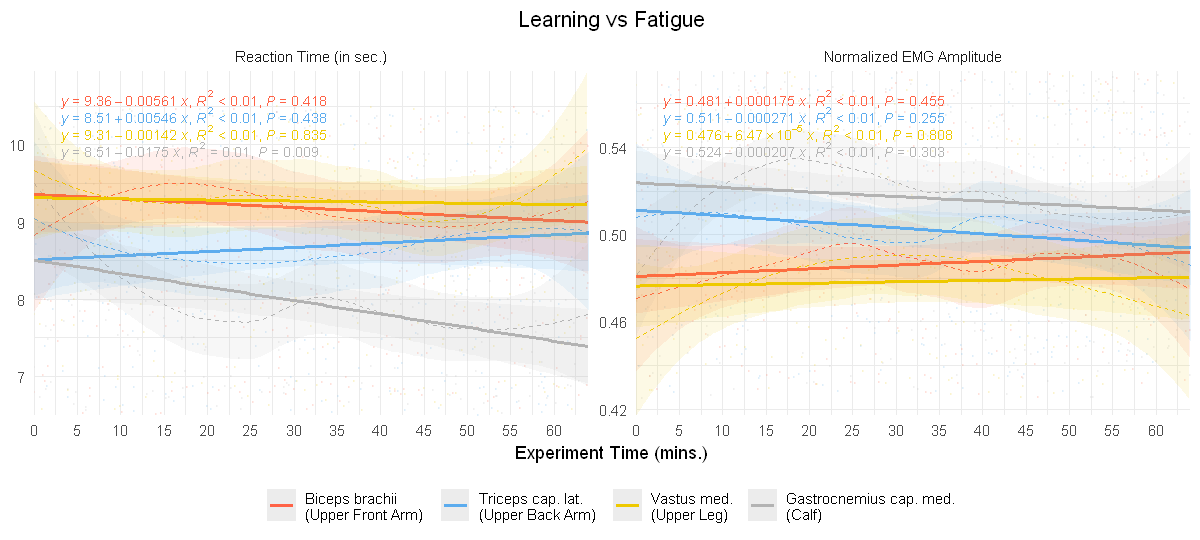

In [27]:
# Plot Amplitude and Reaction Time together

plot <- ggplot(plotVals, aes(x = ExperimentTime / 600, y = Value, color = Muscle, fill = Muscle)) +   
            #geom_errorbar(aes(ymin = mean, ymax = mean), width=0, alpha=0.5, size=0.5) +  
            facet_wrap(.~Measure, scales = "free")+
            scale_x_continuous(breaks = scales::breaks_width(5)) + 
            coord_cartesian(xlim=c(0,64), expand = FALSE) +   
            #scale_y_continuous(breaks = scales::breaks_width(1), limits=c(6,11)) +
            #geom_line(size = 0.6) + 
            geom_point(data = plotVals[plotVals$Measure == "Reaction Time (in sec.)" & plotVals$Value > 6.5 & plotVals$Value < 10.5,], alpha = 0.1, size = 0.1) + 
            geom_point(data = plotVals[plotVals$Measure == "Normalized EMG Amplitude" & plotVals$Value > 0.425 & plotVals$Value < 0.575,], alpha = 0.1, size = 0.1) + 
            #geom_smooth(method = 'lm', alpha = 1, size = 0.5, formula = "y~x", se = FALSE, show.legend = FALSE) +
            geom_smooth(method = 'loess', alpha = 0.1, size = 0.5, formula = "y~x", linetype = "dashed") +
            geom_smooth(method = 'loess', alpha = 1, size = 0.5, formula = "y~x", linetype = "dashed", se = FALSE, show.legend = FALSE) +
            ggtitle("Learning vs Fatigue") +
            #geom_wrap(.~Muscle) + 
            #labs(fill = "", color = "") +
            stat_poly_eq(size = 3, aes(label = paste(after_stat(eq.label),
                                         after_stat(rr.label), 
                                         after_stat(p.value.label), 
                                         sep = "*\", \"*"))) +
stat_poly_line(alpha = 0.1) +
  #stat_poly_eq(use_label(c("R2", "F", "p"), sep = "*\", \"*"))+
            ylab("") +  
            #geom_point(data = peaks, aes(x=pos/10,y=val, color="blue"))+
            xlab("Experiment Time (mins.)") + 
            guides(fill = "none") +
            labs(color="", shape = "Minimum Reaction Time") + 
            scale_color_manual(values = cbPalette) +
            scale_fill_manual(values = cbPalette) +
            theme_minimal() + 
            theme(
                plot.title = element_text(hjust = 0.5),
                legend.position = "bottom",
                axis.title.y = element_blank()
            ) 
options(repr.plot.width = 10, repr.plot.height = 4.5) 
plot
ggsave("FatigueVSLearning.pdf", plot, width=10, height=4.5, device=cairo_pdf)

In [22]:
plotValsFct <- na.omit(plotVals)
plotValsFct$ExperimentTime <- as.factor(round(plotValsFct$ExperimentTime / 6000, 0))  
head(plotValsFct)
levels(plotValsFct$ExperimentTime)

#aov <- anova_test(data = plotValsFct[plotValsFct$Measure == "Reaction Time (in sec.)",], dv = Value, wid = SubjectID, within = c(ExperimentTime, Muscle),  effect.size = "pes")
#round_df(get_anova_table(aov, correction = "auto") ) 

print("ANOVA on Reaction Time with Experiment Time as Continous Factor")
aov <- aov(Value ~ ExperimentTime * Muscle + Error(SubjectID / (ExperimentTime + Muscle)), plotValsFct[plotValsFct$Measure == "Reaction Time (in sec.)",])
summary(aov) 


print("ANOVA on Amplitude with Experiment Time as Continous Factor")
aov <- aov(Value ~ ExperimentTime * Muscle + Error(SubjectID / (ExperimentTime + Muscle)), plotValsFct[plotValsFct$Measure == "Normalized EMG Amplitude",])
summary(aov) 
#aov <- anova_test(data = plotValsFct[plotValsFct$Measure == "Normalized EMG Amplitude",], dv = Value, wid = SubjectID, between = c(ExperimentTime, Muscle),  effect.size = "pes")
#round_df(get_anova_table(aov, correction = "auto") ) 

,SubjectID,Muscle,ExperimentTime,Measure,Value
,<fct>,<fct>,<fct>,<fct>,<dbl>
1,107,Triceps cap. lat. (Upper Back Arm),0,Reaction Time (in sec.),8.837184
2,188,Biceps brachii (Upper Front Arm),0,Reaction Time (in sec.),10.784384
3,109,Triceps cap. lat. (Upper Back Arm),0,Reaction Time (in sec.),8.058048
4,194,Vastus med. (Upper Leg),0,Reaction Time (in sec.),7.809088
5,190,Gastrocnemius cap. med. (Calf),0,Reaction Time (in sec.),7.115584
6,198,Vastus med. (Upper Leg),0,Reaction Time (in sec.),8.068864


[1] "0" "1" "2" "3" "4" "5" "6"

[1] "ANOVA on Reaction Time with Experiment Time as Continous Factor"



Error: SubjectID
                      Df Sum Sq Mean Sq
ExperimentTime         6  885.5  147.59
Muscle                 3  171.2   57.06
ExperimentTime:Muscle 11  366.5   33.32

Error: SubjectID:ExperimentTime
                      Df Sum Sq Mean Sq F value Pr(>F)
ExperimentTime         6   55.5   9.245   0.862  0.526
Muscle                 3   24.1   8.042   0.749  0.525
ExperimentTime:Muscle 18   75.8   4.212   0.393  0.987
Residuals             99 1062.3  10.730               

Error: SubjectID:Muscle
                      Df Sum Sq Mean Sq F value   Pr(>F)    
Muscle                 3  617.1  205.70  11.000 1.85e-05 ***
ExperimentTime:Muscle 18  620.7   34.48   1.844   0.0517 .  
Residuals             42  785.4   18.70                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Error: Within
                        Df Sum Sq Mean Sq F value Pr(>F)
ExperimentTime:Muscle   18    198   10.97    1.26  0.205
Residuals             2192  19092    8.71        

[1] "ANOVA on Amplitude with Experiment Time as Continous Factor"



Error: SubjectID
                      Df Sum Sq Mean Sq
ExperimentTime         6 0.8228 0.13714
Muscle                 3 0.5512 0.18373
ExperimentTime:Muscle 11 0.5048 0.04589

Error: SubjectID:ExperimentTime
                      Df Sum Sq  Mean Sq F value Pr(>F)
ExperimentTime         6 0.0881 0.014683   1.182  0.322
Muscle                 3 0.0607 0.020249   1.630  0.187
ExperimentTime:Muscle 18 0.1603 0.008906   0.717  0.786
Residuals             99 1.2295 0.012420               

Error: SubjectID:Muscle
                      Df Sum Sq Mean Sq F value  Pr(>F)   
Muscle                 3 0.4537 0.15124   4.439 0.00849 **
ExperimentTime:Muscle 18 0.7101 0.03945   1.158 0.33686   
Residuals             42 1.4312 0.03408                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Error: Within
                        Df Sum Sq  Mean Sq F value Pr(>F)
ExperimentTime:Muscle   18  0.172 0.009548   0.978  0.483
Residuals             2192 21.410 0.009767        

In [23]:
plotValsFct[plotValsFct$Measure == "Reaction Time (in sec.)",]

,SubjectID,Muscle,ExperimentTime,Measure,Value
,<fct>,<fct>,<fct>,<fct>,<dbl>
1,107,Triceps cap. lat. (Upper Back Arm),0,Reaction Time (in sec.),8.837184
2,188,Biceps brachii (Upper Front Arm),0,Reaction Time (in sec.),10.784384
3,109,Triceps cap. lat. (Upper Back Arm),0,Reaction Time (in sec.),8.058048
4,194,Vastus med. (Upper Leg),0,Reaction Time (in sec.),7.809088
5,190,Gastrocnemius cap. med. (Calf),0,Reaction Time (in sec.),7.115584
6,198,Vastus med. (Upper Leg),0,Reaction Time (in sec.),8.068864
7,106,Biceps brachii (Upper Front Arm),0,Reaction Time (in sec.),11.044480
8,108,Gastrocnemius cap. med. (Calf),0,Reaction Time (in sec.),5.516224
9,196,Triceps cap. lat. (Upper Back Arm),0,Reaction Time (in sec.),3.916032


Muscle,ExperimentTime,Measure,Mean,MeanSD,N,MeanSE,MeanCI
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
Biceps brachii (Upper Front Arm),1,Reaction Time (in sec.),8.7779429,2.91864978,42,0.45035744,0.90951530
Biceps brachii (Upper Front Arm),1,Normalized EMG Amplitude,0.4764717,0.09845683,42,0.01519222,0.03068131
Biceps brachii (Upper Front Arm),2,Reaction Time (in sec.),9.3982250,2.97766474,98,0.30078956,0.59698402
Biceps brachii (Upper Front Arm),2,Normalized EMG Amplitude,0.4691412,0.10916633,98,0.01102746,0.02188646
Biceps brachii (Upper Front Arm),3,Reaction Time (in sec.),9.6890013,3.12025065,76,0.35791730,0.71300782
Biceps brachii (Upper Front Arm),3,Normalized EMG Amplitude,0.5041393,0.09187278,76,0.01053853,0.02099383


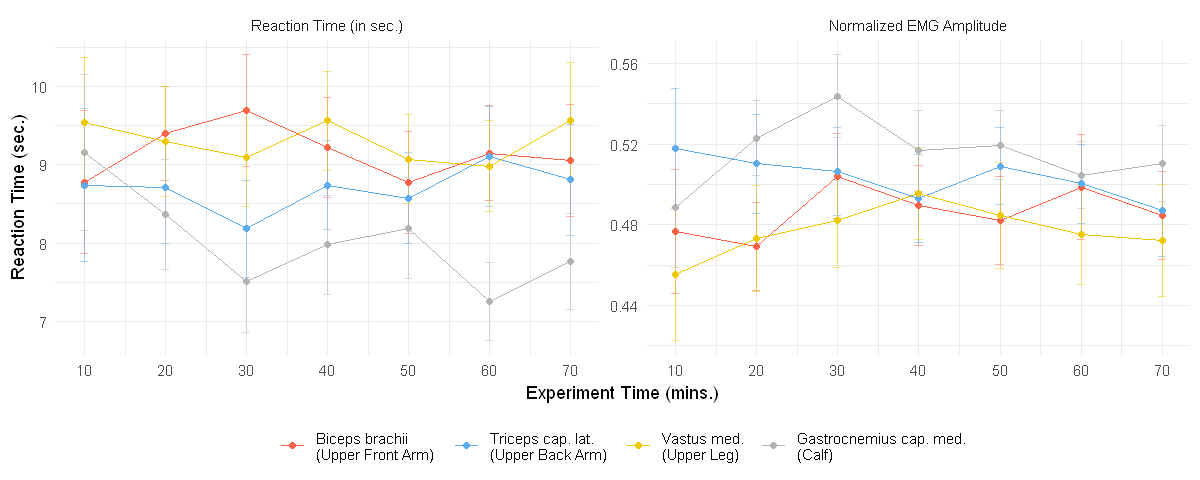

In [24]:
# fatigue vs learning for idiots
 
means <- plotValsFct %>% group_by(Muscle, ExperimentTime, Measure) %>% summarize(
    Mean = mean(Value),
    MeanSD = sd(Value),
    N = n(), .groups = 'drop',) %>% mutate(
    MeanSE = MeanSD / sqrt(N),
    MeanCI = qt(1 - (0.05 / 2), N - 1) * MeanSE) 
 
means$ExperimentTime <- as.numeric(means$ExperimentTime)  
head(means)


plot <- ggplot(means, aes(x = ExperimentTime * 10, y = Mean, color = Muscle, fill = Muscle)) +   
            facet_wrap(.~Measure, scales = "free")+
            geom_errorbar(aes(ymin = Mean - MeanCI, ymax = Mean + MeanCI), width=1, alpha=0.5, size=0.5) +  
            scale_x_continuous(breaks = scales::breaks_width(10)) + 
            #coord_cartesian(ylim = c(6, 11), expand = FALSE) + 
            #scale_y_continuous(breaks = scales::breaks_width(1), limits=c(6,11)) +
            geom_line() + 
            geom_point() +  
            #ggtitle("GSR Signal Stress Test") +
            #geom_wrap(.~Muscle) + 
            ylab("Reaction Time (sec.)") + 
            #geom_point(data = peaks, aes(x=pos/10,y=val, color="blue"))+
            xlab("Experiment Time (mins.)") + 
            #labs(color="Task", linetype="Room") + 
            scale_color_manual(values = cbPalette) +
            theme_minimal() + 
            labs(fill = "", color = "") +
            theme(
                plot.title = element_text(hjust = 0.5),
                legend.position = "bottom"
            ) 
options(repr.plot.width = 10, repr.plot.height = 4) 
plot
ggsave("FatigueVSLearningDiscrete.pdf", plot, width=10, height=4, device=cairo_pdf)

In [ ]:
nrow(data)

In [ ]:
print( Sys.time() - start )
